## Preprocessing of the dataset
    Edge feature: normalization and arcsinh transformation (same as that in DeepDynaTree)
    Node feature: only keep the dynamic labels of nodes (background, static, decay and static)
    
    Chop 20% terminal branches
    Feature visualization about the chopped data (which includes patterns for model to learn).
    Visualization of chopped trees


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp
from tqdm import tqdm
from collections import Counter

ds_name = 'TB'
date = '20230222'
ds_folder = f'/mnt/data2/chaoyue/data/cleaned_{ds_name}_data_20230112'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mnt/data2/chaoyue/data/cleaned_TB_data_20230112/cleaned_edge.csv
/mnt/data2/chaoyue/data/cleaned_TB_data_20230112/cleaned_node.csv
/mnt/data2/chaoyue/data/cleaned_TB_data_20230112/chopped_TB_edge_20230222.csv


In [2]:
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [3]:
node_df = pd.read_csv(f'{ds_folder}/cleaned_node.csv')
edge_df = pd.read_csv(f'{ds_folder}/cleaned_edge.csv')

In [4]:
print('Shape of node data is', node_df.shape)
print('Shape of edge data is', edge_df.shape)

Shape of node data is (21424954, 21)
Shape of edge data is (21417772, 5)


In [5]:
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,...,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node
0,10000.0,Background,A,static,0.0,0.157937,1586.0,1.0,186.0,-117.223302,...,30586.0,1.552298,129.705180,0.706522,8481.079313,concave,0.278616,1.0,2020-01-16,1
1,10000.0,Background,A,static,0.0,0.157937,1586.0,1.0,186.0,-117.223302,...,30586.0,1.552298,129.705180,0.706522,8481.079313,concave,0.278616,1.0,2020-01-29,3
2,10000.0,Background,A,static,0.0,0.157937,1586.0,1.0,186.0,-117.223302,...,30586.0,1.552298,129.705180,0.706522,8481.079313,concave,0.278616,1.0,2020-02-09,6
3,10000.0,Background,A,static,0.0,0.157937,1586.0,1.0,186.0,-117.223302,...,30586.0,1.552298,129.705180,0.706522,8481.079313,concave,0.278616,1.0,2020-01-28,1715
4,10000.0,Background,A,static,0.0,0.157937,1586.0,1.0,186.0,-117.223302,...,30586.0,1.552298,129.705180,0.706522,8481.079313,concave,0.278616,1.0,2020-02-12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21424949,9.0,c3,C,static,0.0,0.801352,147.0,1.0,42.0,4.730986,...,1028.0,1.581860,10.560938,0.450000,180.207596,concave_convex,0.257143,-9.0,2020-06-03,615
21424950,9.0,c3,C,static,0.0,0.801352,147.0,1.0,42.0,4.730986,...,1028.0,1.581860,10.560938,0.450000,180.207596,concave_convex,0.257143,-9.0,2020-05-25,3181
21424951,9.0,c3,C,static,0.0,0.801352,147.0,1.0,42.0,4.730986,...,1028.0,1.581860,10.560938,0.450000,180.207596,concave_convex,0.257143,-9.0,2020-05-16,3119
21424952,9.0,c3,C,static,0.0,0.801352,147.0,1.0,42.0,4.730986,...,1028.0,1.581860,10.560938,0.450000,180.207596,concave_convex,0.257143,-9.0,2020-05-20,302


In [8]:
node_df[node_df['dynamic']=='growth']

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,...,PD,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node
3146,10000.0,c3,D,growth,0.166006,0.811901,25.0,1.0,46.0,-29.364917,...,305.0,0.553898,3.378314,0.136364,60.235946,concave,0.243902,-2.5,2020-07-13,2760
3147,10000.0,c3,D,growth,0.166006,0.811901,25.0,1.0,46.0,-29.364917,...,305.0,0.553898,3.378314,0.136364,60.235946,concave,0.243902,-2.5,2020-07-07,2759
3148,10000.0,c3,D,growth,0.166006,0.811901,25.0,1.0,46.0,-29.364917,...,305.0,0.553898,3.378314,0.136364,60.235946,concave,0.243902,-2.5,2020-07-13,1368
3149,10000.0,c3,D,growth,0.166006,0.811901,25.0,1.0,46.0,-29.364917,...,305.0,0.553898,3.378314,0.136364,60.235946,concave,0.243902,-2.5,2020-07-13,1667
3150,10000.0,c3,D,growth,0.166006,0.811901,25.0,1.0,46.0,-29.364917,...,305.0,0.553898,3.378314,0.136364,60.235946,concave,0.243902,-2.5,2020-07-04,2757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21424737,9.0,c2,D,growth,0.210745,0.774734,226.0,1.0,78.0,-35.378205,...,1225.0,3.025652,14.055985,0.552632,313.774081,concave,0.305085,2.0,2020-06-25,1875
21424738,9.0,c2,D,growth,0.210745,0.774734,226.0,1.0,78.0,-35.378205,...,1225.0,3.025652,14.055985,0.552632,313.774081,concave,0.305085,2.0,2020-06-25,1876
21424739,9.0,c2,D,growth,0.210745,0.774734,226.0,1.0,78.0,-35.378205,...,1225.0,3.025652,14.055985,0.552632,313.774081,concave,0.305085,2.0,2020-06-25,1877
21424740,9.0,c2,D,growth,0.210745,0.774734,226.0,1.0,78.0,-35.378205,...,1225.0,3.025652,14.055985,0.552632,313.774081,concave,0.305085,2.0,2020-06-25,1878


In [6]:
node_df[node_df['cluster_id']=='Background']['state'].unique()

array(['A'], dtype=object)

In [7]:
onetree = node_df[node_df['sim']==1000]

In [8]:
node_df['cluster_id'].unique()

array(['Background', 'c1', 'c2', 'c3', 'c4'], dtype=object)

In [9]:
node_df['state'].unique()

array(['A', 'B', 'E', 'D', 'C'], dtype=object)

In [10]:
edge_df

,from,to,weight1,weight2,sim
0,1712,1713,1,0.000996,10000
1,1713,1,6,0.005691,10000
2,1713,1714,10,0.009116,10000
3,1714,1715,8,0.006960,10000
4,1715,3,1,0.000896,10000
...,...,...,...,...,...
21417767,3598,3603,6,0.005175,9
21417768,3603,1334,9,0.007632,9
21417769,3603,3604,4,0.003721,9
21417770,3604,1539,5,0.004630,9


In [11]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(edge_tree_ids)
tree_ids = edge_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 7182


### Edge feature processing

In [12]:
aly_edge_feat_cols = ['weight1', 'weight2']
aly_edge_df = edge_df[aly_edge_feat_cols]

In [13]:
aly_edge_df.describe()

,weight1,weight2
count,2.141777e+07,2.141777e+07
mean,9.344073e+00,8.409853e-03
std,8.026247e+00,7.258798e-03
min,0.000000e+00,0.000000e+00
25%,3.000000e+00,2.529303e-03
50%,8.000000e+00,7.179433e-03
75%,1.300000e+01,1.180804e-02
max,1.940000e+02,1.833679e-01


array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

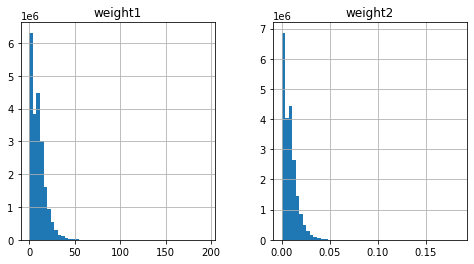

In [14]:
aly_edge_df.hist(bins=50,figsize=(8,4))

In [15]:
label_map = {'static':0,'decay':1,'growth':2}

In [16]:
node_df["dynamic_cat"] = node_df["dynamic"].map(label_map)
node_df["dynamic"] = node_df["dynamic"].astype('category')

In [17]:
node_df["dynamic_cat"].unique()

array([0, 1, 2])

### calculate start time and end time for each branch

In [18]:
edge_df["start_time"] = np.nan
edge_df["end_time"] = np.nan

In [19]:
edge_df

,from,to,weight1,weight2,sim,start_time,end_time
0,1712,1713,1,0.000996,10000,NaN,NaN
1,1713,1,6,0.005691,10000,NaN,NaN
2,1713,1714,10,0.009116,10000,NaN,NaN
3,1714,1715,8,0.006960,10000,NaN,NaN
4,1715,3,1,0.000896,10000,NaN,NaN
...,...,...,...,...,...,...,...
21417767,3598,3603,6,0.005175,9,NaN,NaN
21417768,3603,1334,9,0.007632,9,NaN,NaN
21417769,3603,3604,4,0.003721,9,NaN,NaN
21417770,3604,1539,5,0.004630,9,NaN,NaN


In [20]:
node_tree_ids

array([1.000e+04, 1.002e+03, 1.004e+03, ..., 9.990e+02, 9.900e+01,
       9.000e+00])

In [21]:

# check the direction of edges on the tree
pbar = tqdm(total = len(node_tree_ids), position=0, leave=True)
for tree_id in node_tree_ids:
    temp_df = edge_df[edge_df['sim']==tree_id]
    if set(Counter(temp_df['to'].values).values())!=set([1]): # the dst nodes are unique
        print(tree_id)
    if temp_df.index[-1]-temp_df.index[0]+1 != len(temp_df.index): # the edges on the same tree are grouped together in edge_df
        print(tree_id)
    pbar.update(n=1)
pbar.close()

100%|█████████████████████████████████████████████████| 7182/7182 [01:47<00:00, 66.59it/s]


In [22]:
st_list = []
et_list = []
# This add start time and end time of each branch
pbar = tqdm(total = len(node_tree_ids), position=0, leave=True)
for tree_id in node_tree_ids:
    temp_df = edge_df[edge_df['sim']==tree_id]
    root = list(set(temp_df['from'].values)-set(temp_df['to'].values))[0]
    temp_dict = {}
    temp_time = {}
    for idx in temp_df.index:
        node_from = temp_df.loc[idx,'from']
        node_to = temp_df.loc[idx,'to']
        if node_from in temp_dict.keys():
            temp_dict[node_from].append(node_to)
        else:
            temp_dict[node_from] = [node_to]
    queue = [root]
    temp_time[root] = 0
    while queue:
        node = queue.pop(0)
        if node in temp_dict.keys():
            queue = queue + temp_dict[node]
        if node == root:
            continue
        else:
            slice_df = temp_df.iloc[np.where(temp_df['to'].values==node)[0]]
            temp_time[node] =  temp_time[slice_df['from'].values[0]] + slice_df['weight1'].values[0]
    temp_df['start_time'] = temp_df['from'].map(temp_time)
    temp_df['end_time'] = temp_df['to'].map(temp_time)
    st_list += list(temp_df['start_time'].values)
    et_list += list(temp_df['end_time'].values)
    pbar.update(n=1)
pbar.close()
edge_df["start_time"] = st_list
edge_df["end_time"] = et_list

100%|███████████████████████████████████████████████| 7182/7182 [1:30:38<00:00,  1.32it/s]


#simulated data
edge_df['start_time'] = np.random.randint(0, 1000, len(edge_df))
edge_df['end_time'] = edge_df['start_time']+1

### add cluster id in edge_df

In [23]:
node_df

,sim,cluster_id,state,dynamic,dynamic_rparam,v_sampling_fraction,v_cluster_size,v_fraction_state,v_timespan,gamma,...,R0,abs_growth_rate,fraction_time_growth,r_max,ltt_shape,cherries,BLD,date,node,dynamic_cat
0,10000.0,Background,A,static,0.0,0.157937,1586.0,1.0,186.0,-117.223302,...,1.552298,129.705180,0.706522,8481.079313,concave,0.278616,1.0,2020-01-16,1,0
1,10000.0,Background,A,static,0.0,0.157937,1586.0,1.0,186.0,-117.223302,...,1.552298,129.705180,0.706522,8481.079313,concave,0.278616,1.0,2020-01-29,3,0
2,10000.0,Background,A,static,0.0,0.157937,1586.0,1.0,186.0,-117.223302,...,1.552298,129.705180,0.706522,8481.079313,concave,0.278616,1.0,2020-02-09,6,0
3,10000.0,Background,A,static,0.0,0.157937,1586.0,1.0,186.0,-117.223302,...,1.552298,129.705180,0.706522,8481.079313,concave,0.278616,1.0,2020-01-28,1715,0
4,10000.0,Background,A,static,0.0,0.157937,1586.0,1.0,186.0,-117.223302,...,1.552298,129.705180,0.706522,8481.079313,concave,0.278616,1.0,2020-02-12,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21424949,9.0,c3,C,static,0.0,0.801352,147.0,1.0,42.0,4.730986,...,1.581860,10.560938,0.450000,180.207596,concave_convex,0.257143,-9.0,2020-06-03,615,0
21424950,9.0,c3,C,static,0.0,0.801352,147.0,1.0,42.0,4.730986,...,1.581860,10.560938,0.450000,180.207596,concave_convex,0.257143,-9.0,2020-05-25,3181,0
21424951,9.0,c3,C,static,0.0,0.801352,147.0,1.0,42.0,4.730986,...,1.581860,10.560938,0.450000,180.207596,concave_convex,0.257143,-9.0,2020-05-16,3119,0
21424952,9.0,c3,C,static,0.0,0.801352,147.0,1.0,42.0,4.730986,...,1.581860,10.560938,0.450000,180.207596,concave_convex,0.257143,-9.0,2020-05-20,302,0


In [24]:
cluster_id_list = []
temp = -1
pbar = tqdm(total = len(node_tree_ids), position=0, leave=True)
for tree_id in node_tree_ids:
    temp_edge_df = edge_df[edge_df['sim']==tree_id]
    temp_node_df = node_df[node_df['sim']==tree_id]
    id_dict = temp_node_df.set_index(['node'])['cluster_id'].to_dict()
    temp_edge_df['dst_cluster_id'] = temp_edge_df['to'].map(id_dict)
    cluster_id_list += list(temp_edge_df['dst_cluster_id'].values)
    
    if temp_edge_df.index[0] > temp:
        temp = temp_edge_df.index[0]
    else:
        print(tree_id)
    pbar.update(n=1)
pbar.close()
edge_df['dst_cluster_id'] = cluster_id_list

100%|█████████████████████████████████████████████████| 7182/7182 [08:28<00:00, 14.12it/s]


In [25]:
edge_df

,from,to,weight1,weight2,sim,start_time,end_time,dst_cluster_id
0,1712,1713,1,0.000996,10000,0,1,Background
1,1713,1,6,0.005691,10000,1,7,Background
2,1713,1714,10,0.009116,10000,1,11,Background
3,1714,1715,8,0.006960,10000,11,19,Background
4,1715,3,1,0.000896,10000,19,20,Background
...,...,...,...,...,...,...,...,...
21417767,3598,3603,6,0.005175,9,141,147,Background
21417768,3603,1334,9,0.007632,9,147,156,Background
21417769,3603,3604,4,0.003721,9,147,151,Background
21417770,3604,1539,5,0.004630,9,151,156,Background


In [26]:
edge_df.to_csv(f'{ds_folder}/chopped_{ds_name}_edge_{date}.csv')

In [67]:
edge_df.sort_values('end_time',inplace=True)
edge_df

,from,to,weight1,weight2,sim,start_time,end_time,dst_cluster_id
0,1712,1713,1,0.000996,10000,0,1,Background
2571606,1733,1,1,0.000927,2103,0,1,Background
14916589,1797,1,1,0.000862,7263,0,1,Background
7672499,1304,1305,1,0.000944,420,0,1,Background
14906644,1740,1741,1,0.000988,7260,0,1,Background
...,...,...,...,...,...,...,...,...
6952261,684,457,12,0.011141,390,225,237,Background
6952255,680,523,24,0.023064,390,213,237,Background
6952246,675,475,5,0.004866,390,232,237,Background
17086865,147,75,10,0.008477,8194,227,237,c1


In [19]:
edge_df = pd.read_csv(f'{ds_folder}/chopped_{ds_name}_edge_{date}.csv',index_col=0)
edge_df

,from,to,weight1,weight2,sim,start_time,end_time,dst_cluster_id
0,1712,1713,1,0.000996,10000,0,1,Background
1,1713,1,6,0.005691,10000,1,7,Background
2,1713,1714,10,0.009116,10000,1,11,Background
3,1714,1715,8,0.006960,10000,11,19,Background
4,1715,3,1,0.000896,10000,19,20,Background
...,...,...,...,...,...,...,...,...
21417767,3598,3603,6,0.005175,9,141,147,Background
21417768,3603,1334,9,0.007632,9,147,156,Background
21417769,3603,3604,4,0.003721,9,147,151,Background
21417770,3604,1539,5,0.004630,9,151,156,Background


### Chop the branches

In [20]:
def node_id_mapping(tree_df, removed_leaves, n_nodes):
    map_dict = {}
    remain_nodes = n_nodes - len(removed_leaves)
    j = remain_nodes + 1
    for i in removed_leaves['to'].values: # update id of chopped nodes
        map_dict[i] = j
        j += 1
    j = 1
    for i in range(n_nodes):
        if i+1 in removed_leaves['to'].values:
            continue
        else:
            map_dict[i+1] = j
            j += 1
    if j != remain_nodes + 1:
        print(j)
        print(remain_nodes)
    temp_df['new_from'] = temp_df['from'].map(map_dict)
    temp_df['new_to'] = temp_df['to'].map(map_dict)
    removed_leaves['new_from'] = removed_leaves['from'].map(map_dict)
    removed_leaves['new_to'] = removed_leaves['to'].map(map_dict)
    return temp_df, removed_leaves, map_dict

In [21]:
from sklearn.model_selection import  train_test_split
train_ids = node_df['sim'].unique()
train_chop = {}
map_dicts = {}
remain_nodes = []
remain_frac = []
pbar = tqdm(total = len(train_ids), position=0, leave=True)
for i,tree_id in enumerate(train_ids):
    while 1: # if the chopping happens at top, redo chopping
        temp_df = edge_df[edge_df['sim']==tree_id]
        cluster_ids = temp_df['dst_cluster_id'].unique()
        j = 0
        for cid in cluster_ids:
            if cid == 'Background':
                continue
            cluster_df = temp_df[temp_df['dst_cluster_id'] == cid]
            cidx = cluster_df.index
            chop_rate = np.random.rand(1)
            removed_nodes = cluster_df.loc[cluster_df.index[int(np.floor(len(cidx)*chop_rate)):],]
            count_node_parent = dict(Counter(removed_nodes['from'].values)) 
            removed_parent = cluster_df[cluster_df['from'].isin(count_node_parent.keys())]
            count_parent_node = dict(Counter(removed_parent['from'].values)) 
            return_node_parent = [node for node,value in count_node_parent.items() if value!=count_parent_node[node]]
            removed_nodes = removed_nodes[~removed_nodes['from'].isin(return_node_parent)]
            remain_nodes.append(len(cluster_df)-len(removed_nodes))
            remain_frac.append((len(cluster_df)-len(removed_nodes))/len(cluster_df))
            if j == 0:
                removed_full_nodes = removed_nodes
                j = 1
            else:
                removed_full_nodes = pd.concat([removed_full_nodes,removed_nodes])
        # update node id after chopping
        temp_df, removed_leaves, map_dict = node_id_mapping(temp_df, removed_full_nodes, max(list(temp_df['to'].values)+list(temp_df['from'].values))) # update node ids: chopped nodes will be in tail
        temp_df1 = temp_df.drop(removed_leaves.index)
        a = len(set(list(temp_df1['new_from'].values)+list(temp_df1['new_to'].values)))
        b = max(max(temp_df1['new_from'].values),max(temp_df1['new_to'].values))
        c = len(temp_df1)
        if a ==c+1 or b==c+1:
            break
    
    train_chop[tree_id] = list(removed_leaves['new_to'].values) # record chopped nodes ids
    map_dicts[tree_id] = map_dict
    
    
    if i == 0:
        chop_df = removed_leaves
        df = temp_df
    else:
        chop_df = pd.concat([chop_df, removed_leaves])
        if i % 50 == 0:
            df = temp_df
        else:
            df = pd.concat([df, temp_df])
    if i % 50 == 49:
        if i == 49:
            new_edge_df = df
        else:
            new_edge_df = pd.concat([new_edge_df,df])
            del df   
    pbar.update(n=1)
pbar.close()

100%|█████████████████████████████████████████████████| 7182/7182 [09:06<00:00, 13.15it/s]


In [22]:
new_edge_df = pd.concat([new_edge_df,df])

In [23]:
new_edge_df = new_edge_df.drop(chop_df.index)

In [24]:
chop_df.index

Int64Index([     804,      805,      807,      808,      809,      810,
                 811,      812,      813,      814,
            ...
            21417480, 21417481, 21417482, 21417483, 21417484, 21417485,
            21417486, 21417487, 21417488, 21417489],
           dtype='int64', length=978181)

In [25]:
new_edge_df

,from,to,weight1,weight2,sim,start_time,end_time,dst_cluster_id,new_from,new_to
0,1712,1713,1,0.000996,10000,0,1,Background,1624,1625
1,1713,1,6,0.005691,10000,1,7,Background,1625,1
2,1713,1714,10,0.009116,10000,1,11,Background,1625,1626
3,1714,1715,8,0.006960,10000,11,19,Background,1626,1627
4,1715,3,1,0.000896,10000,19,20,Background,1627,3
...,...,...,...,...,...,...,...,...,...,...
21417767,3598,3603,6,0.005175,9,141,147,Background,3478,3483
21417768,3603,1334,9,0.007632,9,147,156,Background,3483,1280
21417769,3603,3604,4,0.003721,9,147,151,Background,3483,3484
21417770,3604,1539,5,0.004630,9,151,156,Background,3484,1471


In [26]:
np.save('map_dicts.npy',map_dicts)
np.save('train_chop.npy',train_chop)

In [27]:
chopped_cluster = {}
pbar = tqdm(total = len(train_ids), position=0, leave=True)
for i,tree_id in enumerate(train_ids):
    temp_df = node_df[node_df['sim']==tree_id][['sim','cluster_id','state','dynamic','node','dynamic_cat']]
    temp_df['node'] = temp_df['node'].map(map_dicts[tree_id])
    temp_chop_df = temp_df[temp_df['node'].isin(train_chop[tree_id])]
    chopped_cluster[tree_id] = temp_chop_df['cluster_id'].unique()
    if i == 0:
        df = temp_df
        train_chop_node_df = temp_chop_df
    else:
        train_chop_node_df = pd.concat([train_chop_node_df, temp_chop_df])
        if i % 50 == 0:
            df = temp_df
        else:
            df = pd.concat([df, temp_df])
    if i % 50 == 49:
        if i == 49:
            new_node_df = df
        else:
            new_node_df = pd.concat([new_node_df,df])
            del df  
    pbar.update(n=1)
pbar.close()

100%|█████████████████████████████████████████████████| 7182/7182 [04:04<00:00, 29.34it/s]


In [28]:
new_node_df = pd.concat([new_node_df,df])

In [29]:
new_node_df

,sim,cluster_id,state,dynamic,node,dynamic_cat
0,10000.0,Background,A,static,1,0
1,10000.0,Background,A,static,3,0
2,10000.0,Background,A,static,6,0
3,10000.0,Background,A,static,1627,0
4,10000.0,Background,A,static,12,0
...,...,...,...,...,...,...
21424949,9.0,c3,C,static,3570,0
21424950,9.0,c3,C,static,3071,0
21424951,9.0,c3,C,static,3035,0
21424952,9.0,c3,C,static,3571,0


In [30]:
train_chop_node_df

,sim,cluster_id,state,dynamic,node,dynamic_cat
3027,10000.0,c1,B,static,3213,0
3028,10000.0,c1,B,static,3199,0
3029,10000.0,c1,B,static,3214,0
3030,10000.0,c1,B,static,3212,0
3031,10000.0,c1,B,static,3220,0
...,...,...,...,...,...,...
21424945,9.0,c3,C,static,3562,0
21424948,9.0,c3,C,static,3569,0
21424949,9.0,c3,C,static,3570,0
21424952,9.0,c3,C,static,3571,0


In [31]:
new_node_df = new_node_df[['sim','cluster_id','state','dynamic','node','dynamic_cat']].drop(train_chop_node_df.index)
new_node_df

,sim,cluster_id,state,dynamic,node,dynamic_cat
0,10000.0,Background,A,static,1,0
1,10000.0,Background,A,static,3,0
2,10000.0,Background,A,static,6,0
3,10000.0,Background,A,static,1627,0
4,10000.0,Background,A,static,12,0
...,...,...,...,...,...,...
21424941,9.0,c3,C,static,3072,0
21424946,9.0,c3,C,static,3070,0
21424947,9.0,c3,C,static,3036,0
21424950,9.0,c3,C,static,3071,0


In [32]:
len(new_node_df)-len(new_edge_df)

7182

In [33]:
new_node_df['sim'].unique()

array([1.000e+04, 1.002e+03, 1.004e+03, ..., 9.990e+02, 9.900e+01,
       9.000e+00])

In [34]:
#check if the number of nodes in each tree is as what I assume:

In [35]:
for i in new_node_df['sim'].unique():
    test_df = new_node_df[new_node_df['sim']==i].sort_values(by='node')
    if len(test_df) != test_df['node'].iloc[-1]:
        print('error')
    test_edge_df = new_edge_df[new_edge_df['sim']==i]
    if len(set(list(test_edge_df['new_from'].values)+list(test_edge_df['new_to'].values))) != len(test_df):
        print('error')
        print(i)
    if max(max(test_edge_df['new_from'].values),max(test_edge_df['new_to'].values)) != len(test_df):
        print('error')
        print(i)

In [36]:
new_node_df['cluster_id'].unique()

array(['Background', 'c1', 'c2', 'c3', 'c4'], dtype=object)

In [37]:
remain_nodes = []
for i,tree_id in enumerate(train_ids):
    temp_df = new_node_df[new_node_df['sim']==tree_id]
    for c_id in chopped_cluster[tree_id]:
        remain_nodes.append(len(temp_df[temp_df['cluster_id']==c_id]))

Text(0, 0.5, 'Number of clusters')

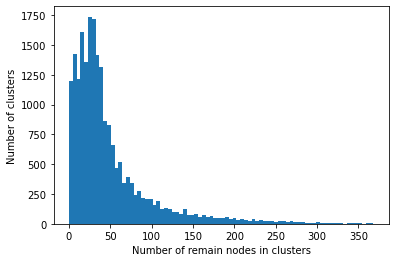

In [38]:
plt.hist(remain_nodes,80)
plt.xlabel('Number of remain nodes in clusters')
plt.ylabel('Number of clusters')

Text(0, 0.5, 'Number of clusters')

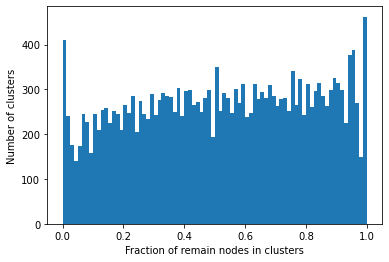

In [39]:
plt.hist(remain_frac,80)
plt.xlabel('Fraction of remain nodes in clusters')
plt.ylabel('Number of clusters')

In [40]:
node_tree_ids = new_node_df['sim'].unique()
edge_tree_ids = new_edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(edge_tree_ids)
tree_ids = edge_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 7182


In [41]:
print ('Shape of node data is', new_node_df.shape)
print ('Shape of edge data is', new_edge_df.shape)

Shape of node data is (20446773, 6)
Shape of edge data is (20439591, 10)


In [42]:
new_node_df.reset_index(inplace=True)
new_edge_df.reset_index(inplace=True)

### Split the train/test sets

In [43]:
random_seed = 123
date='20230223'
np.random.seed(random_seed)
split_folder = f'/mnt/data2/chaoyue/data/ddf_{ds_name}_{date}/split_rs{random_seed}'
os.makedirs(split_folder, exist_ok=True)


#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 5745, Test: 1437
[1351 3119 5348 1280 3594 3436  634 3554  447 1400]


In [44]:
train_edge_df = new_edge_df[new_edge_df['sim'].isin(train_ids)]
test_edge_df = new_edge_df[new_edge_df['sim'].isin(test_ids)]

print(f'Train edges: {train_edge_df.shape[0]}')
print(f'Test edges: {test_edge_df.shape[0]}')

Train edges: 16338554
Test edges: 4101037


In [45]:
train_node_df = new_node_df[new_node_df['sim'].isin(train_ids)]
test_node_df = new_node_df[new_node_df['sim'].isin(test_ids)]

print(f'Train nodes: {train_node_df.shape[0]}')
print(f'Test nodes: {test_node_df.shape[0]}')

Train nodes: 16344299
Test nodes: 4102474


### Normalize the edge weights

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

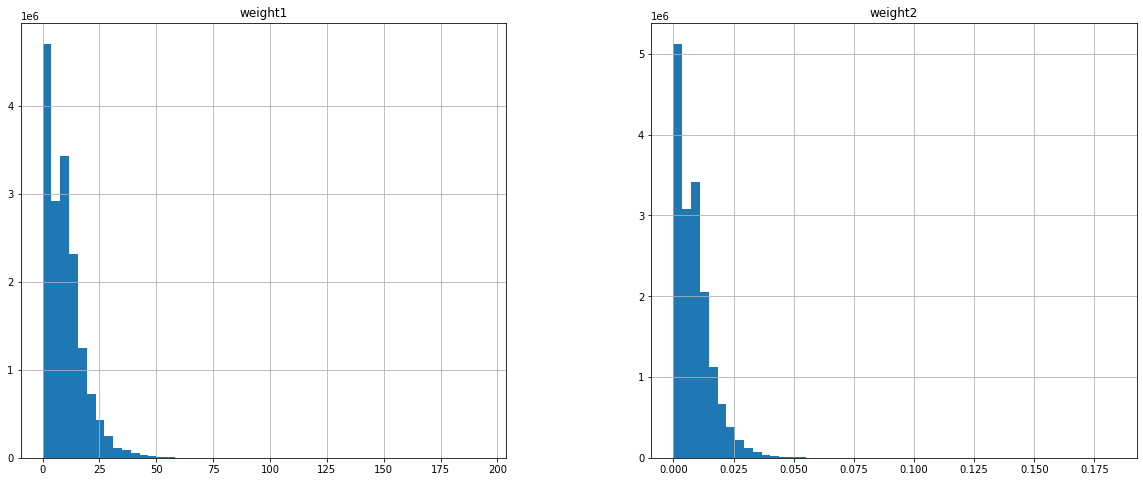

In [46]:
train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [47]:
train_edge_df['weight1'].describe()

count    1.633855e+07
mean     9.469561e+00
std      8.068051e+00
min      0.000000e+00
25%      3.000000e+00
50%      8.000000e+00
75%      1.300000e+01
max      1.940000e+02
Name: weight1, dtype: float64

In [48]:
train_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(train_edge_df['weight1'])

In [49]:
train_edge_df['weight2'].describe()

count    1.633855e+07
mean     8.522832e-03
std      7.296792e-03
min      0.000000e+00
25%      2.592525e-03
50%      7.302484e-03
75%      1.192833e-02
max      1.833679e-01
Name: weight2, dtype: float64

In [50]:
train_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(train_edge_df['weight2'])

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh'}>,
        <AxesSubplot:title={'center':'weight2_arsinh'}>]], dtype=object)

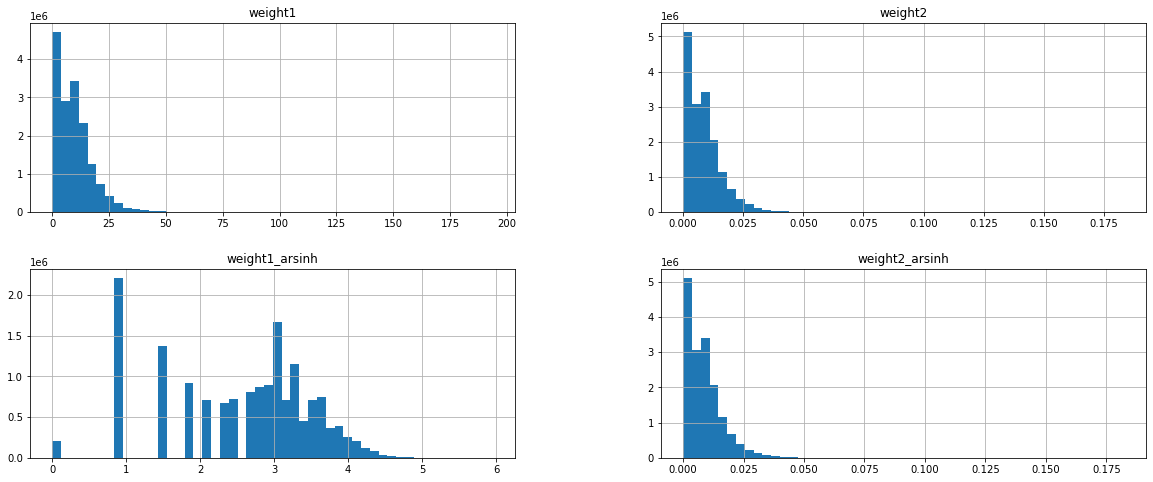

In [51]:
aly_edge_feat_cols += ['weight1_arsinh', 'weight2_arsinh']

train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [52]:
from sklearn import preprocessing

# Standardization edge features
std_scaler = preprocessing.StandardScaler().fit(train_edge_df[aly_edge_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in aly_edge_feat_cols]

norm_train_vals = std_scaler.transform(train_edge_df[aly_edge_feat_cols])
norm_train_edge_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_edge_df.index)
train_edge_df = pd.concat([train_edge_df, norm_train_edge_df], axis=1)

In [53]:
train_edge_df

,index,from,to,weight1,weight2,sim,start_time,end_time,dst_cluster_id,new_from,new_to,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
0,0,1712,1713,1,0.000996,10000,0,1,Background,1624,1625,0.881374,0.000996,-1.049765,-1.031560,-1.656686,-1.031664
1,1,1713,1,6,0.005691,10000,1,7,Background,1625,1,2.491780,0.005691,-0.430037,-0.388133,-0.046434,-0.388139
2,2,1713,1714,10,0.009116,10000,1,11,Background,1625,1626,2.998223,0.009115,0.065746,0.081229,0.459961,0.081284
3,3,1714,1715,8,0.006960,10000,11,19,Background,1626,1627,2.776472,0.006960,-0.182146,-0.214225,0.238231,-0.214207
4,4,1715,3,1,0.000896,10000,19,20,Background,1627,3,0.881374,0.000896,-1.049765,-1.045278,-1.656686,-1.045384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20439586,21417767,3598,3603,6,0.005175,9,141,147,Background,3478,3483,2.491780,0.005175,-0.430037,-0.458829,-0.046434,-0.458846
20439587,21417768,3603,1334,9,0.007632,9,147,156,Background,3483,1280,2.893444,0.007632,-0.058200,-0.122111,0.355192,-0.122081
20439588,21417769,3603,3604,4,0.003721,9,147,151,Background,3483,3484,2.094713,0.003721,-0.677928,-0.658135,-0.443463,-0.658181
20439589,21417770,3604,1539,5,0.004630,9,151,156,Background,3484,1471,2.312438,0.004630,-0.553983,-0.533454,-0.225758,-0.533482


In [54]:
print(std_scaler.mean_, std_scaler.scale_)

[9.46956059e+00 8.52283178e-03 2.53821809e+00 8.52239764e-03] [8.06805104e+00 7.29679147e-03 1.00009538e+00 7.29563256e-03]


In [55]:
scaler_dict = {'mean':std_scaler.mean_,'std':std_scaler.scale_}
scaler_dict

{'mean': array([9.46956059e+00, 8.52283178e-03, 2.53821809e+00, 8.52239764e-03]),
 'std': array([8.06805104e+00, 7.29679147e-03, 1.00009538e+00, 7.29563256e-03])}

In [56]:
np.save("scaler.npy",scaler_dict)

In [57]:
new_dict = np.load("scaler.npy",allow_pickle=True)

In [58]:
# reverse transform
np.sinh(train_edge_df['weight1_arsinh-norm'].values*new_dict.item()['std'][2]+new_dict.item()['mean'][2])

array([ 1.,  6., 10., ...,  4.,  5.,  5.])

In [59]:
raw_edge_feat_cols = aly_edge_feat_cols
norm_edge_feat_cols = [f'{org_feat_col}-norm' for org_feat_col in aly_edge_feat_cols]

In [60]:
raw_edge_feat_cols

['weight1', 'weight2', 'weight1_arsinh', 'weight2_arsinh']

In [61]:
norm_edge_feat_cols

['weight1-norm', 'weight2-norm', 'weight1_arsinh-norm', 'weight2_arsinh-norm']

In [62]:
test_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(test_edge_df['weight1'])
test_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(test_edge_df['weight2'])
test_edge_df

,index,from,to,weight1,weight2,sim,start_time,end_time,dst_cluster_id,new_from,new_to,weight1_arsinh,weight2_arsinh
12005,12702,427,1,16,0.015608,1009,0,16,Background,377,1,3.466711,0.015607
12006,12703,427,428,8,0.007059,1009,0,8,Background,377,378,2.776472,0.007059
12007,12704,428,2,12,0.011834,1009,8,20,Background,378,2,3.179785,0.011834
12008,12705,428,429,3,0.002402,1009,8,11,Background,378,379,1.818446,0.002402
12009,12706,429,430,1,0.000910,1009,11,12,Background,379,380,0.881374,0.000910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20413409,21390573,1680,3158,11,0.009079,9990,0,11,Background,1637,3084,3.093102,0.009079
20413410,21390574,3158,2,5,0.004672,9990,11,16,Background,3084,2,2.312438,0.004672
20413411,21390575,3158,3159,13,0.012127,9990,11,24,Background,3084,3085,3.259573,0.012127
20413412,21390576,3159,1,3,0.002469,9990,24,27,Background,3085,1,1.818446,0.002469


In [63]:
norm_test_vals = std_scaler.transform(test_edge_df[raw_edge_feat_cols])
norm_test_edge_df = pd.DataFrame(norm_test_vals, columns=norm_edge_feat_cols, index=test_edge_df.index)
test_edge_df = pd.concat([test_edge_df, norm_test_edge_df], axis=1)

array([[<AxesSubplot:title={'center':'weight1-norm'}>,
        <AxesSubplot:title={'center':'weight2-norm'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh-norm'}>,
        <AxesSubplot:title={'center':'weight2_arsinh-norm'}>]],
      dtype=object)

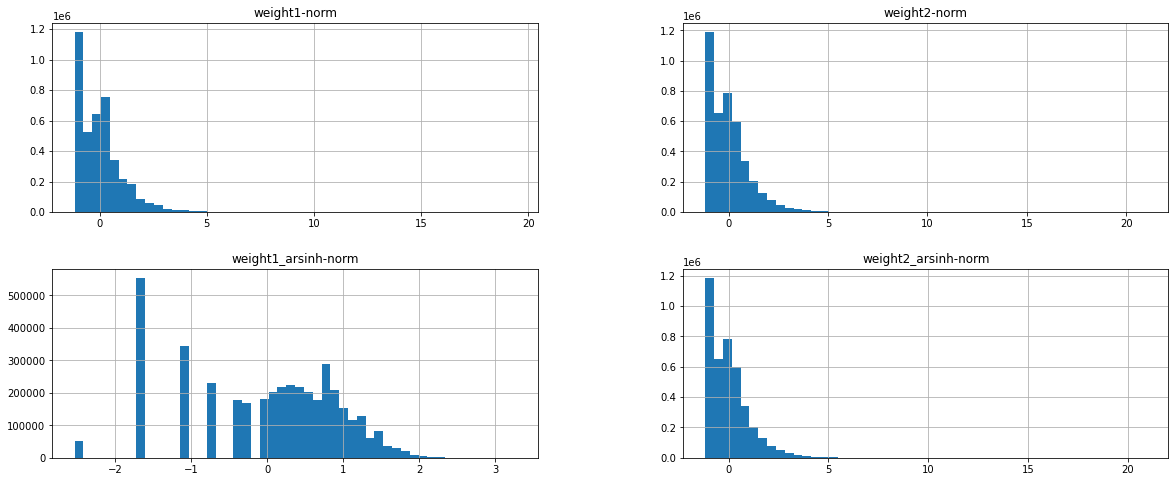

In [64]:
test_edge_df[norm_edge_feat_cols].hist(bins=50,figsize=(20,8))

### Split train/valid/test sets and save them

In [65]:
train_ids, valid_ids = train_test_split(train_ids, test_size=0.25)
print(f"Train: {len(train_ids)}, Valid: {len(valid_ids)}")
print(valid_ids[:10])

Train: 4308, Valid: 1437
[5159 4457 1706 3928 8340 2498 1886 9148 3022 1073]


In [66]:
train_full_df = train_edge_df[train_edge_df['sim'].isin(train_ids)]
valid_full_df = train_edge_df[train_edge_df['sim'].isin(valid_ids)]

print(f'Train edge: {train_full_df.shape[0]}')
print(f'Valid edge: {valid_full_df.shape[0]}')
train_full_df.head()

Train edge: 12250009
Valid edge: 4088545


,index,from,to,weight1,weight2,sim,start_time,end_time,dst_cluster_id,new_from,new_to,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
3104,3255,1522,2,27,0.024959,1002,0,27,Background,1379,2,3.989327,0.024956,2.172822,2.252488,1.450970,2.252550
3105,3256,1522,1523,8,0.006421,1002,0,8,Background,1379,1380,2.776472,0.006421,-0.182146,-0.287981,0.238231,-0.287973
3106,3257,1523,1,10,0.009244,1002,8,18,Background,1380,1,2.998223,0.009244,0.065746,0.098821,0.459961,0.098878
3107,3258,1523,1524,16,0.012902,1002,8,24,Background,1380,1381,3.466711,0.012902,0.809420,0.600145,0.928404,0.600251
3108,3259,1524,1525,7,0.006240,1002,24,31,Background,1381,1382,2.644121,0.006240,-0.306091,-0.312870,0.105893,-0.312866


In [67]:
train_full_node_df = train_node_df[train_node_df['sim'].isin(train_ids)]
valid_full_node_df = train_node_df[train_node_df['sim'].isin(valid_ids)]

print(f'Train node: {train_full_node_df.shape[0]}')
print(f'Valid node: {valid_full_node_df.shape[0]}')
train_full_node_df.head()

Train node: 12254317
Valid node: 4089982


,index,sim,cluster_id,state,dynamic,node,dynamic_cat
3105,3256,1002.0,Background,A,static,2,0
3106,3257,1002.0,Background,A,static,1,0
3107,3258,1002.0,Background,A,static,3,0
3108,3259,1002.0,Background,A,static,6,0
3109,3260,1002.0,Background,A,static,7,0


In [68]:
train_full_df = train_full_df[['sim','new_from','new_to','weight1_arsinh-norm','weight2_arsinh-norm']]
valid_full_df = valid_full_df[['sim','new_from','new_to','weight1_arsinh-norm','weight2_arsinh-norm']]
test_edge_df = test_edge_df[['sim','new_from','new_to','weight1_arsinh-norm','weight2_arsinh-norm']]

In [69]:
# Save the train/test to the disk

train_full_node_df.to_csv(f'{split_folder}/train.csv', index=False)
valid_full_node_df.to_csv(f'{split_folder}/valid.csv', index=False)
test_node_df.to_csv(f'{split_folder}/test.csv', index=False)
train_full_df.to_csv(f'{split_folder}/train_edge.csv', index=False)
valid_full_df.to_csv(f'{split_folder}/valid_edge.csv', index=False)
test_edge_df.to_csv(f'{split_folder}/test_edge.csv', index=False)


In [70]:
onetree= train_full_node_df[train_full_node_df['sim']==1000]

In [23]:
onetree[onetree['cluster_id']=='Background']['dynamic'].unique()

array(['static'], dtype=object)

In [98]:
c1 = 0
c2 = 0
c3 = 0
for onetree_id in train_ids:
    onetree_node_df = train_full_node_df[train_full_node_df['sim'] == onetree_id]
    onetree_edge_df = train_full_df[train_full_df['sim'] == onetree_id]
    leaves = list(set(onetree_edge_df['new_to'].values)-set(onetree_edge_df['new_from'].values))
    leaf_df = onetree_node_df[onetree_node_df['node'].isin(leaves)]
    c1 += len(leaf_df[leaf_df['dynamic'] == 'static'])
    c2 += len(leaf_df[leaf_df['dynamic'] == 'decay'])
    c3 += len(leaf_df[leaf_df['dynamic'] == 'growth'])

In [99]:
c1

9275764

In [100]:
c2

98381

In [101]:
c3

214998

<BarContainer object of 3 artists>

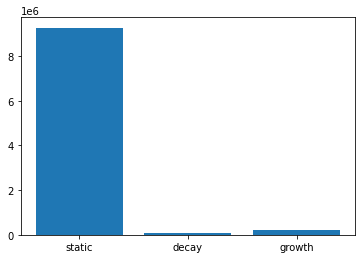

In [102]:
plt.bar(['static','decay','growth'], [c1,c2,c3])

In [103]:
[(c1+c2+c3)/(i*3) for i in [c1,c2,c3]]

[0.3445949034494625, 32.48982018885761, 14.867026670015536]

### Visualization of a chopped tree

In [133]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids = train_full_df['sim'].unique()
vis_tree_id = train_ids[100]
print(vis_tree_id)

1143


In [134]:
onetree_node_df = train_full_node_df[train_full_node_df['sim'] == vis_tree_id] 
onetree_edge_df = train_full_df[train_full_df['sim'] == vis_tree_id]

In [135]:
onetree_node_df

,index,sim,cluster_id,state,dynamic,node,dynamic_cat
521348,568871,1143,Background,A,static,3,0
521349,568872,1143,Background,A,static,7,0
521350,568873,1143,Background,A,static,1755,0
521351,568874,1143,Background,A,static,37,0
521352,568875,1143,Background,A,static,85,0
...,...,...,...,...,...,...,...
524907,572615,1143,c5,E,static,3517,0
524908,572625,1143,c5,E,static,527,0
524909,572626,1143,c5,E,static,1132,0
524910,572637,1143,c5,E,static,3521,0


In [136]:
onetree_edge_df

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm
521202,1143,1831,1832,-0.089291,-0.462374
521203,1143,1832,1833,0.534553,0.190518
521204,1143,1833,1834,0.103273,-0.243031
521205,1143,1834,1835,-0.619706,-0.801237
521206,1143,1835,1836,-1.625870,-1.092431
...,...,...,...,...,...
524760,1143,3562,3563,-1.022152,-0.947080
524761,1143,3563,489,1.080935,1.113273
524762,1143,3563,3564,0.647057,0.520103
524763,1143,3564,593,-0.089291,-0.387021


In [137]:
len(set(list(onetree_edge_df['new_from'].values)+list(onetree_edge_df['new_to'].values)))

3564

In [138]:
import dgl
import networkx as nx
import torch
import pygraphviz as pgv

In [139]:
src_ids = torch.tensor(onetree_edge_df['new_from'].values)
dst_ids = torch.tensor(onetree_edge_df['new_to'].values)

# Note: the start idx of the node is 0 not 1. But simulation node starts with 1
# We need substract 1 to the node idx for edges and nodes files.
src_ids -= 1
dst_ids -= 1

In [140]:
g = dgl.graph((src_ids, dst_ids))
nx_g = dgl.to_networkx(g)

print(f'Nodes: {g.number_of_nodes()}')
print(f'Edges: {g.number_of_edges()}')



Nodes: 3564
Edges: 3563


In [141]:
sorted_onetree_node_df = onetree_node_df.sort_values(by='node')
sorted_onetree_node_df

,index,sim,cluster_id,state,dynamic,node,dynamic_cat
523174,570697,1143,Background,A,static,1,0
522592,570115,1143,Background,A,static,2,0
521348,568871,1143,Background,A,static,3,0
522568,570091,1143,Background,A,static,4,0
523345,570868,1143,Background,A,static,5,0
...,...,...,...,...,...,...,...
524472,571995,1143,Background,A,static,3560,0
524471,571994,1143,Background,A,static,3561,0
524470,571993,1143,Background,A,static,3562,0
524498,572021,1143,Background,A,static,3563,0


In [142]:

print(sorted_onetree_node_df['node'].values)
n_nodes = sorted_onetree_node_df.shape[0]
sorted_onetree_node_df.tail()

[   1    2    3 ... 3562 3563 3564]


,index,sim,cluster_id,state,dynamic,node,dynamic_cat
524472,571995,1143,Background,A,static,3560,0
524471,571994,1143,Background,A,static,3561,0
524470,571993,1143,Background,A,static,3562,0
524498,572021,1143,Background,A,static,3563,0
524497,572020,1143,Background,A,static,3564,0


In [143]:
set(sorted_onetree_node_df['dynamic'].values)

{'decay', 'growth', 'static'}

In [144]:
#g.ndata['feat'] = torch.tensor(sorted_onetree_node_df[node_feat_cols].values)
g.ndata['label'] = torch.tensor(sorted_onetree_node_df['dynamic'].map({'bg':3,'decay':0,'growth':1,'static':2}).values)


defaultdict(<function <lambda> at 0x7f1d61d051f0>, {2: 3433, 0: 73, 1: 58})


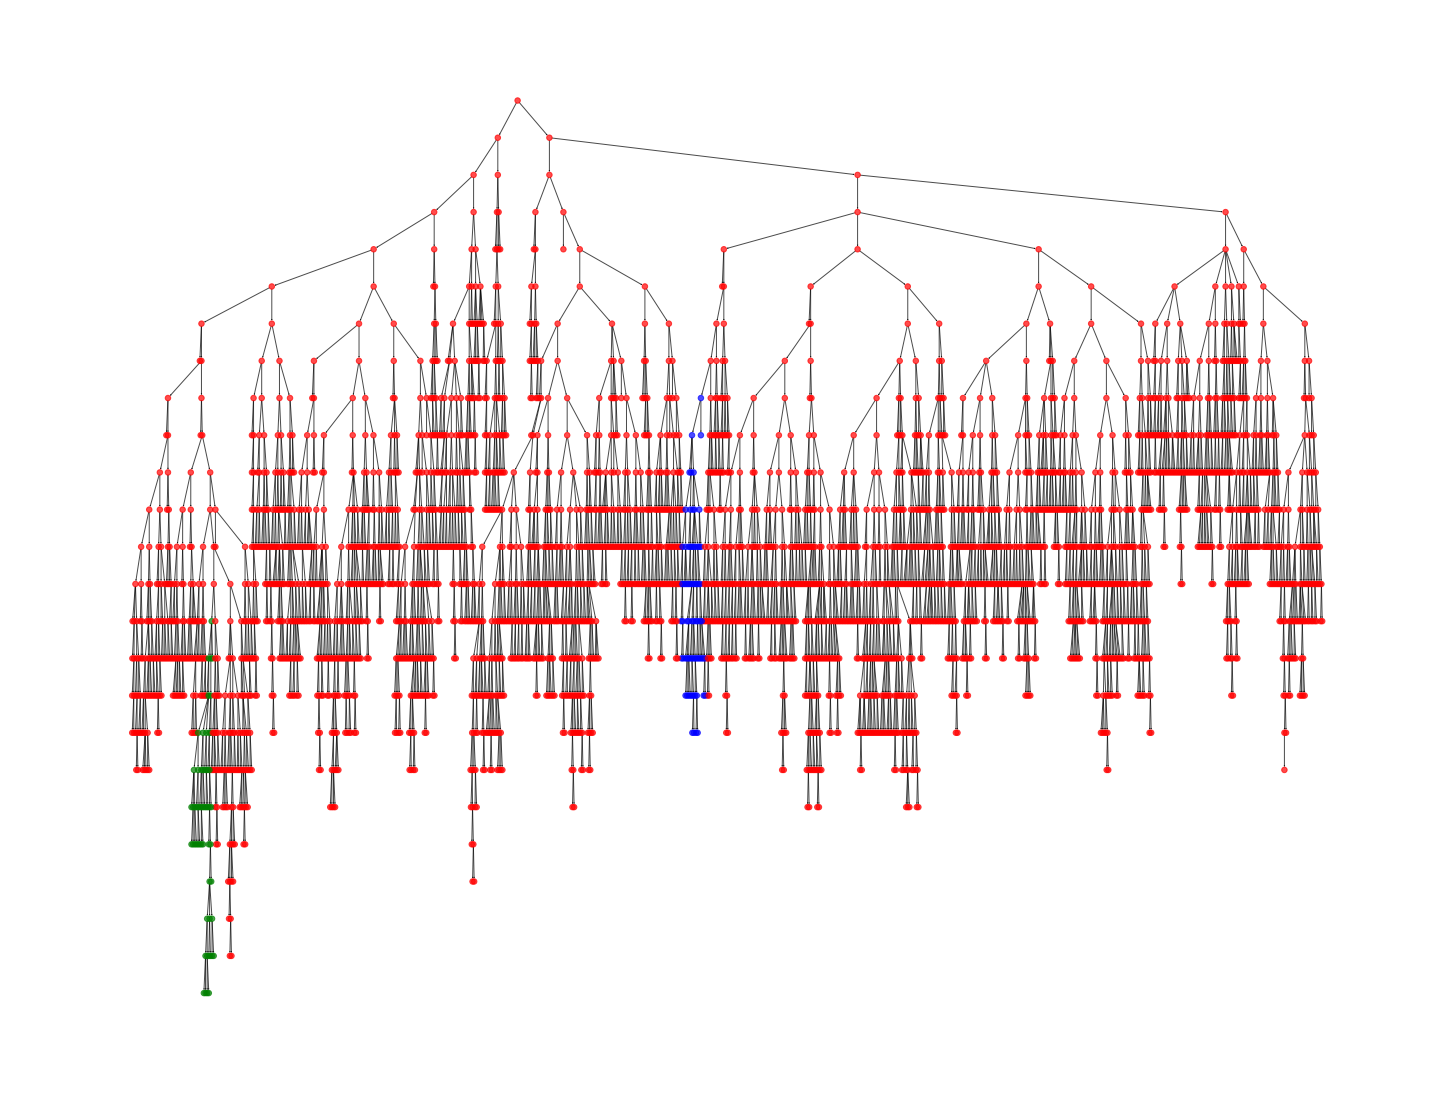

In [145]:
from collections import defaultdict
plt.figure(figsize=(20, 15))
color_map = []
node_labels = g.ndata['label'].numpy()
label_counter = defaultdict(lambda: 0)

for node_id in nx_g:
    node_label = node_labels[node_id]
    if node_label == 3:
        label_counter['bg'] += 1
        color_map.append('gray')
    else:
        if node_label == 0:  # decay
            color_map.append('blue')
        elif node_label == 1:   # growth
            color_map.append('green')
        elif node_label == 2:   # static
            color_map.append('red')
        label_counter[node_label] += 1
            
print(label_counter)
pos = nx.nx_agraph.graphviz_layout(nx_g, prog='dot')
nx.draw(nx_g, pos, with_labels=False, node_size=30, node_color=color_map, alpha=.7, arrowsize=1)